In [1]:
print("Hello World!")

Hello World!


# Card Counting Detectorbot


This project is a DNN to take an input WAV file and count the number of cards from the audio.



<img src="images/sound.png" style="width:1000px;height:150px;">



In [991]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
import pandas as pd
import pydub 
import imageio
from td_utils import *
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import os
from pydub import AudioSegment
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from keras.utils import to_categorical

# 1: Data
The data input is X = 1000ms audio file of x_num of cards

Predicted output is y number of cards flipped/fanned in the audio 

## 1.1 - Loading in Training Data
Start with loading in the raw audio from files

Dataset was manually created by repeatedly fanning through a deck of cards at 2 second intervals and splicing those intervals into individual training examples.  Each file contains a different number of cards per deck, which is encoded in the naming convention, so to be used as the ground truth while compiling the input examples.

The reason to address by index is because the index is used as the ground truth for the file for populating the train_y set.

In [1004]:
def load_card_flip_raw_audio__simplified_from_index(letter, idx):
    card_flip = []
    
    for filename in os.listdir("./raw_data/card_flip"):
        file_found = False
        if filename.startswith(letter+ str(idx)):
            raw_audio = AudioSegment.from_wav("./raw_data/card_flip/"+filename)[:60000] #clip to 60s
            file_found = True
            #print(file_found)
            start = 0
            stop = 60000
            step_size = 1000
            padding = AudioSegment.silent(duration=60000)
            raw_audio = padding.overlay(raw_audio) 
            for i in range(start, stop, step_size): #step size of 5s (5000ms) || range in inclusive so you wont overflow
                #print(i, " , ", i+4999)
                card_flip.append(raw_audio[i : i+1000])
            break
    return card_flip, file_found

In [493]:
#l[oad card flip simplified]_from index
#version 2 of the function, and has differnt assumptions to splice up the audio
def load_card_flip_raw_audio__simplified_from_index_2(letter, idx):
    card_flip = []
    
    for filename in os.listdir("./raw_data/card_flip"):
        file_found = False
        if filename.startswith(letter+ str(idx)):
            raw_audio = AudioSegment.from_wav("./raw_data/card_flip/"+filename)[:32000] #clip to 32s
            file_found = True
            #print(file_found)
            start = 2000 #clip first 2 seconds out
            stop = 32000
            step_size = 2000
            padding = AudioSegment.silent(duration=32000)
            raw_audio = padding.overlay(raw_audio) 
            for i in range(start, stop, step_size): #step size of 2s (2000ms) || range in inclusive so you wont overflow
                #print(i, " , ", i+4999)
                card_flip.append(raw_audio[i : i+2000])
            break
    return card_flip, file_found



In [494]:
card_flip, file_found= load_card_flip_raw_audio__simplified_from_index_2('f',7)
print("len(card_flip): " + str(len(card_flip)))

len(card_flip): 15


In [495]:
card_flip[0].export("training_demo.wav", format = "wav")
IPython.display.Audio("training_demo.wav")

In [805]:
def load_pydub_set__simplified():
    start_training_cflips = 3
    max_training_cflips = 10
    train_X = []
    train_y = []
    letters_idx = ['c'] #, 'c', 'd'
    
    for idx in range(start_training_cflips, max_training_cflips+1, 1):
        for letter in letters_idx:
            buffer, file_found = load_card_flip_raw_audio__simplified_from_index(letter, idx)
            if(file_found):
                train_X.extend(buffer)
                y = np.ones(len(buffer))*idx
                train_y = np.append(train_y, y)

    
    
    return train_X, train_y

len(train_X): 240
len(train_y): 240
3.0
1000


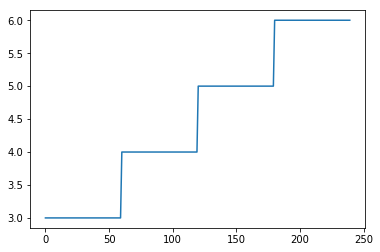

In [806]:
pd_train_X, pd_train_y = load_pydub_set__simplified()
#sanity checks
print("len(train_X): " + str(len(pd_train_X)))
print("len(train_y): " + str(len(pd_train_y)))
print(pd_train_y[10])
plt.plot(pd_train_y)
print(len(pd_train_X[0]))

## 1.2 Data Augmentation functions
A shift in time is a valid data manipulation that retains expectations I have for the test set, while still providing new data for the model to train with.  This reduces the number of actual data points I must manually obtain


In [563]:
def shift_audio_left(pd_audio):
    #take a pydub audio sample, calculate the max valid shift to the left, and shift a 
    #random interval within that amount to the left 
    threshold = 300
    samples = pd_audio.split_to_mono()
    audio_wave = samples[0].get_array_of_samples()
    found = False
    for i in range(len(audio_wave)):
        if audio_wave[i] > threshold:
            found = True
            break
    if found == True:
        #print('found == True, i : ' + str(i))
        rand_shift = np.random.randint(1, i)

    padding = AudioSegment.silent(duration=1000) #assuming 1 second samples
    start = (44100 - rand_shift)/44100
    start = start*-1000 #convert to pydub milliseconds
    output = padding.overlay(pd_audio[start:])
    
    return output

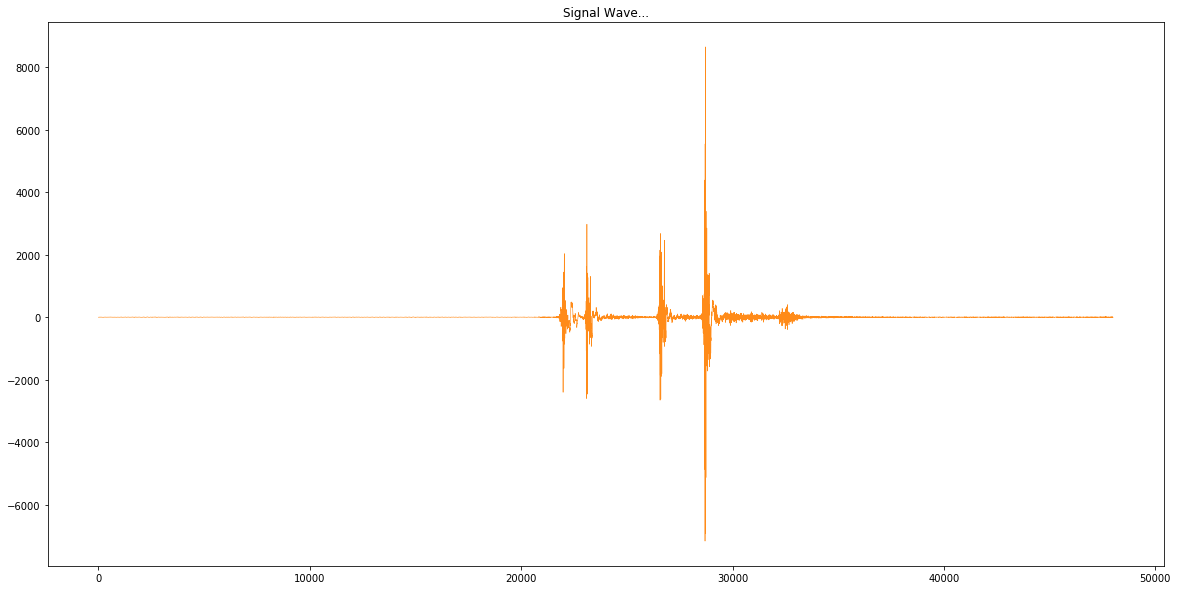

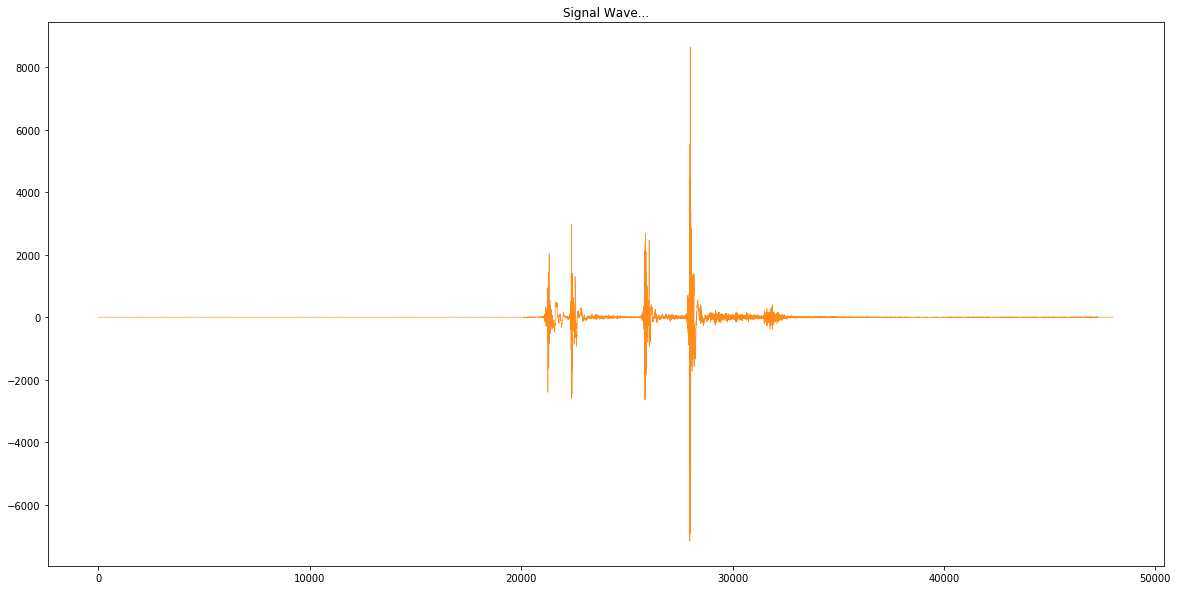

In [592]:
#testing shift left
tp = tp +1
samples = pd_train_X[tp].split_to_mono()
debug_wave = samples[0].get_array_of_samples()
plt.figure(figsize=(20,10))
plt.title('Signal Wave...')
plt.plot(debug_wave, linewidth=0.6, alpha=0.9, color='#ff7f00')

test_ex = shift_audio_left(pd_train_X[tp])

plt.figure(1)
samples = test_ex.split_to_mono()
debug_wave = samples[0].get_array_of_samples()
plt.figure(figsize=(20,10))
plt.title('Signal Wave...')
plt.plot(debug_wave, linewidth=0.6, alpha=0.9, color='#ff7f00')

In [574]:
def shift_audio_right(pd_audio):
    #take a pydub audio sample, calculate the max valid shift to the left, and shift a 
    #random interval within that amount to the left 
    threshold = 200
    samples = pd_audio.split_to_mono()
    audio_wave = samples[0].get_array_of_samples()
    found = False
    for i in range(len(audio_wave)-1, 1, -1): #decrement backwards
        if audio_wave[i] > threshold:
            found = True
            break
    if found == True:
        print('found == True, i : ' + str(i))
        rand_shift = np.random.randint(i, 44100) #hardcode is 88155 plus pad
        
    start = (44100 - rand_shift)/44100
    start = start*1000 #convert to pydub milliseconds    
    shift = AudioSegment.silent(duration=start) #assuming 2 second samples
    #print('start = ' + str(start))
    output = shift + pd_audio #shift _shift amount
    output = output[:1000] #trim to 1s
    
    return output

found == True, i : 13095


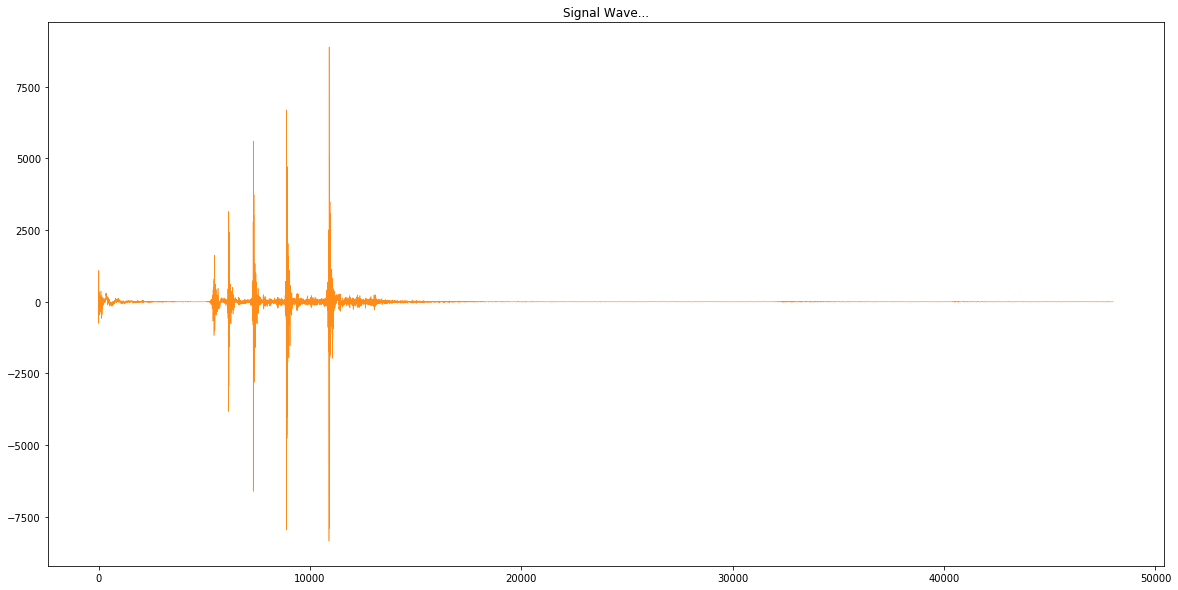

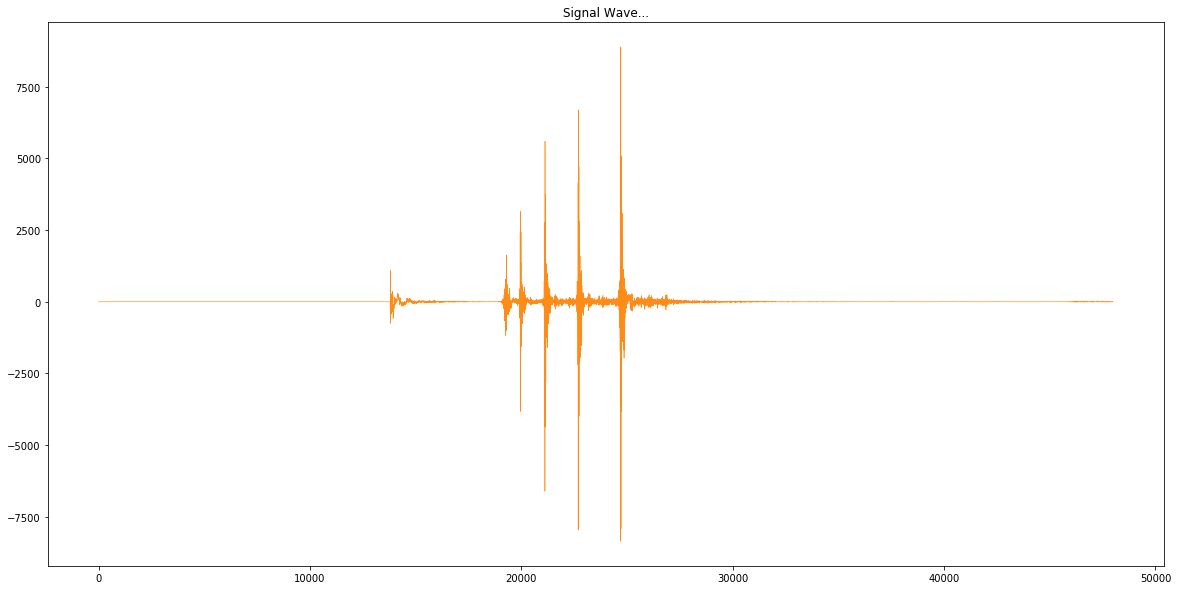

In [606]:
#testing shift right
tp = 272
samples = pd_train_X[tp].split_to_mono()
debug_wave = samples[0].get_array_of_samples()
plt.figure(figsize=(20,10))
plt.title('Signal Wave...')
plt.plot(debug_wave, linewidth=0.6, alpha=0.9, color='#ff7f00')

test_ex = shift_audio_right(pd_train_X[tp])

plt.figure(1)
samples = test_ex.split_to_mono()
debug_wave = samples[0].get_array_of_samples()
plt.figure(figsize=(20,10))
plt.title('Signal Wave...')
plt.plot(debug_wave, linewidth=0.6, alpha=0.9, color='#ff7f00')

## 1.3 Multiplying the Dataset
The shift left and shift right functions allow me to increase my samples by 5x simply by shifting them in time.

In [807]:
def augment_by_4_shifts(pd_set_X_old, pd_set_y_old):
    pd_set_X = []
    pd_set_y = []
    #pd_set_X = pd_set_X_old #copy the lists 
    pre_ag_length = len(pd_set_X_old)
    print(pre_ag_length)
    for j in range(pre_ag_length):
        pd_set_X.append(pd_set_X_old[j])
        pd_set_X.append(shift_audio_left(pd_set_X_old[j]))
        pd_set_X.append(shift_audio_left(pd_set_X_old[j]))
        pd_set_X.append(shift_audio_right(pd_set_X_old[j]))
        pd_set_X.append(shift_audio_right(pd_set_X_old[j]))
        
        pd_set_y.append(pd_set_y_old[j])
        pd_set_y.append(pd_set_y_old[j])
        pd_set_y.append(pd_set_y_old[j])
        pd_set_y.append(pd_set_y_old[j])
        pd_set_y.append(pd_set_y_old[j])
        print('j: ' + str(j))
    
    return pd_set_X, pd_set_y

In [808]:
print('len(pd_train_X): ' + str(len(pd_train_X)))
print('len(pd_train_y): ' + str(len(pd_train_y)))
pd_train_X[180-60] = pd_train_X[182-60] #special case this is a bad couple of samples that causes an error with shifting
pd_train_X[181-60] = pd_train_X[183-60]
pd_train_X[240-60] = pd_train_X[241-60]
pd_train_X[271-60] = pd_train_X[273-60]
pd_train_X[272-60] = pd_train_X[273-60]
aug_train_X, aug_train_y = augment_by_4_shifts(pd_train_X, pd_train_y)

print('len(aug_train_X): ' + str(len(aug_train_X)))
print('len(aug_train_y): ' + str(len(aug_train_y)))

len(pd_train_X): 240
len(pd_train_y): 240
240
found == True, i : 29166
found == True, i : 29166
j: 0
found == True, i : 26595
found == True, i : 26595
j: 1
found == True, i : 12661
found == True, i : 12661
j: 2
found == True, i : 11085
found == True, i : 11085
j: 3
found == True, i : 12471
found == True, i : 12471
j: 4
found == True, i : 16080
found == True, i : 16080
j: 5
found == True, i : 21306
found == True, i : 21306
j: 6
found == True, i : 21851
found == True, i : 21851
j: 7
found == True, i : 20814
found == True, i : 20814
j: 8
found == True, i : 22142
found == True, i : 22142
j: 9
found == True, i : 25888
found == True, i : 25888
j: 10
found == True, i : 24749
found == True, i : 24749
j: 11
found == True, i : 22513
found == True, i : 22513
j: 12
found == True, i : 27304
found == True, i : 27304
j: 13
found == True, i : 29522
found == True, i : 29522
j: 14
found == True, i : 33472
found == True, i : 33472
j: 15
found == True, i : 27781
found == True, i : 27781
j: 16
found == Tru

found == True, i : 22670
found == True, i : 22670
j: 161
found == True, i : 22852
found == True, i : 22852
j: 162
found == True, i : 21933
found == True, i : 21933
j: 163
found == True, i : 22684
found == True, i : 22684
j: 164
found == True, i : 20175
found == True, i : 20175
j: 165
found == True, i : 13773
found == True, i : 13773
j: 166
found == True, i : 13771
found == True, i : 13771
j: 167
found == True, i : 13928
found == True, i : 13928
j: 168
found == True, i : 14286
found == True, i : 14286
j: 169
found == True, i : 17805
found == True, i : 17805
j: 170
found == True, i : 24035
found == True, i : 24035
j: 171
found == True, i : 24516
found == True, i : 24516
j: 172
found == True, i : 26370
found == True, i : 26370
j: 173
found == True, i : 25233
found == True, i : 25233
j: 174
found == True, i : 24525
found == True, i : 24525
j: 175
found == True, i : 22517
found == True, i : 22517
j: 176
found == True, i : 23730
found == True, i : 23730
j: 177
found == True, i : 26808
found 

## <span style = "color:black">1.4 Converting Audio to Spectrogram </span>

<span style="color:blue">convert_to_spec_set</span> is used to take the pydub AudioSegment and convert to 2d spectrogram set such that the output is (samples, time, bins (fft))


In [610]:
def convert_to_spec_set(pd_train_X, pd_train_y):
    fn = "audio_examples/converter.wav"
    nfft = 32
    m = len(pd_train_X)
    pd_train_X[0].export(fn, format='wav')
    rate, data = get_wav_info(fn)
    x,img = g_s(rate, data, nfft,1)
    i,j = x.shape
    
    train_X_spec = np.zeros((m,j,i))
    train_y_spec = pd_train_y
    

    for idx in range(m):
        
        pd_train_X[idx].export(fn, format='wav')
        rate, data = get_wav_info(fn)
        x,img = g_s(rate, data, nfft,1)
        train_X_spec[idx,:,:] = x.swapaxes(0,1)
        
    return train_X_spec, train_y_spec

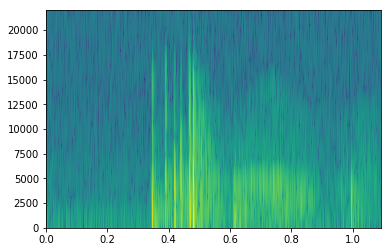

In [811]:
train_X_spec, train_y_spec = convert_to_spec_set(aug_train_X, aug_train_y)

## <span style = "color:black">1.5 Annotate Flip location in spectrogram<span/>
I think I need to provide a line example for each instance, so i must annotate the (part of the) set.




In [612]:
def annotate_single_flip_spec(spec, y):
    #spec is 2d spectrogram in, y is true number of flips, 
    # !! spec should come in as (time, bins)
    #output is a binary truth of sample with 1 point high at the time the flip occured
    #algorithm overview: there spectrogram is summed for each point in time, and tested at decending
    #    thresholds to annotate the flip locations, there is a keepout window to reduce instances where single
    #    flip is triggered as mulitple y values
    spec = np.sum(spec, axis = 1)
    output = np.zeros(len(spec))
    current_num_y = 0
    width_keepout_post = 5
    width_keepout_pre = 3
    thresholds = [100000, 50000, 40000, 30000, 20000, 15000, 10000, 9000, 8000, 7000, 6000, 5000, 4000, 3000, 2000]
    for thr in thresholds:
        i = 1
        while i < len(spec):
            if spec[i] > thr:
                valid = True
                taken = np.nonzero(output)
                for j in taken[0]:
                    if i in range(j-width_keepout_pre, j+width_keepout_post): #
                        valid = False
                if valid == True:
                    output[(i-width_keepout_pre):(i+width_keepout_post)] = 1
                    current_num_y +=1
                if(current_num_y == y):
                    return output, current_num_y
                #print(i)
                i += width_keepout_post
            i += 1
        
    return output, current_num_y

In [613]:
def annotate_all_spec(t_X, t_y):
    train_y = np.zeros((len(t_X), len(t_X[0])))
    for i in range(len(t_X)):
        train_y[i], _ = annotate_single_flip_spec(t_X[i], t_y[i])   
    return train_y

In [812]:
train_y_anno = annotate_all_spec(train_X_spec, train_y_spec)
print(train_y_anno.shape)

(1200, 1548)


2


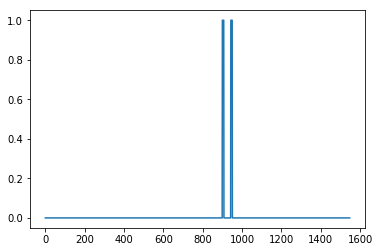

In [636]:
#test annotate_single_flip_spec
tp = tp + 1
my_output, current_num_y = annotate_single_flip_spec(train_X_spec[tp], train_y_spec[tp])
print(current_num_y)
plt.plot(my_output)

## 1.6 Clean Annotations
Since the annotation is not done manually but through a naive algorithm, sometimes it gets fooled, so the following cells increament through the set and allow you to assign a bad annotation to another sample that is a kgu

In [618]:
def clean_annotations(testpoint):
    pic = train_X_spec[testpoint].swapaxes(-2,-1) # i need to swap axis so i looks the way i expect
    plt.figure(figsize=(14,4))
    plt.title('testpoint...'+ ' y = :' + str(train_y_spec[testpoint]))
    plt.imshow(pic)
    plt.xlim(0, len(train_X_spec[0]))
    plt.gca().invert_yaxis()
    sum_columns = np.sum(train_X_spec[testpoint], axis = 1)
    #print(sum_columns.shape)
    a = np.expand_dims(sum_columns, -1)

    plt.figure(1) 
    plt.figure(figsize=(14,4))
    plt.title('testpoint...'+ ' y = :' + str(train_y_spec[testpoint]))
    y_plot, _ = annotate_single_flip_spec(train_X_spec[testpoint], train_y_spec[testpoint])
    plt.plot(y_plot)
    plt.xlim(0, len(train_X_spec[0]))

In [514]:
train_X_spec[testpoint] = train_X_spec[testpoint-1]
train_y_spec[testpoint] = train_y_spec[testpoint-1]
print(testpoint)

50


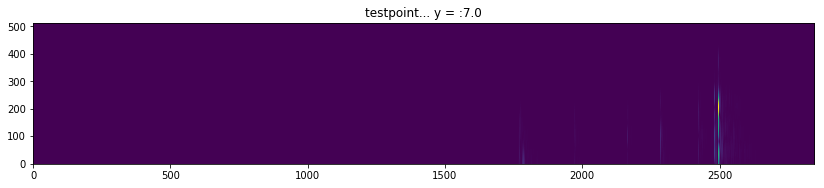

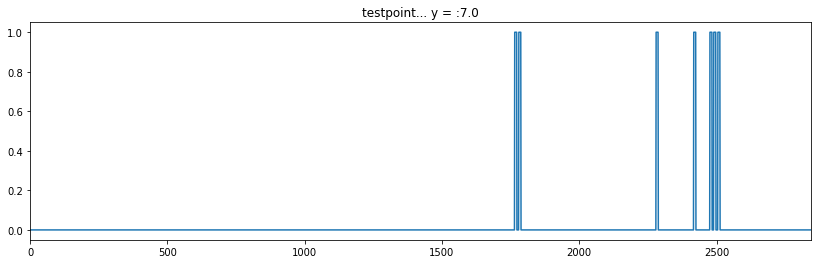

In [518]:
testpoint = testpoint + 1
clean_annotations(testpoint)

## 1.7 Clean up Set
There are a few known bad samples, so i will replace them with other samples that are fine and have a couple of extra copies 

In [46]:
problems = [180, 181]

#this is manual if small enough
train_X_spec[180] = train_X_spec[182]
train_y_spec[180] = train_y_spec[182]
train_X_spec[181] = train_X_spec[183]
train_y_spec[181] = train_y_spec[183]

print('problems corrected!')

problems corrected!


## 1.8 Split Train & Test

(1200, 1548, 2)
X_train_s.shape : (960, 1548, 513)
y_train_is_flip.shape : (960, 1548, 1)
y_train_regression.shape : (960,)
y_test_is_flip.shape : (240, 1548, 1)
y_test_regression.shape : (240,)


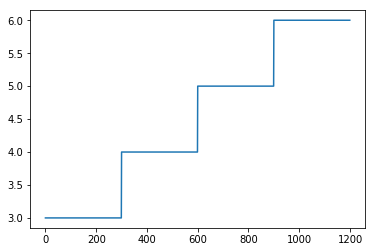

In [813]:
#need to keep both outputs (binary_is_flip and regression #of flips) together before train/test split, then separate
#again for model
train_y_together = np.zeros([len(train_y_spec), len(train_y_anno[0]), 2])
print(train_y_together.shape)
train_y_together[:,:,0] = train_y_anno
train_y_together[:,0,1] = train_y_spec 
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(train_X_spec, train_y_together, test_size=.2)

y_train_is_flip_ = y_train_s[:,:,0]
y_train_is_flip = np.expand_dims(y_train_is_flip_, axis = -1)
y_train_regression = y_train_s[:,0,1]
y_test_is_flip_ = y_test_s[:,:,0]
y_test_is_flip = np.expand_dims(y_test_is_flip_, axis = -1)
y_test_regression = y_test_s[:,0,1]

#sanity check lengths and distribution
print('X_train_s.shape : ' + str(X_train_s.shape))
print('y_train_is_flip.shape : ' + str(y_train_is_flip.shape))
print('y_train_regression.shape : ' + str(y_train_regression.shape))
print('y_test_is_flip.shape : ' + str(y_test_is_flip.shape))
print('y_test_regression.shape : ' + str(y_test_regression.shape))
plt.plot(train_y_spec)
#plt.show

(1548,)

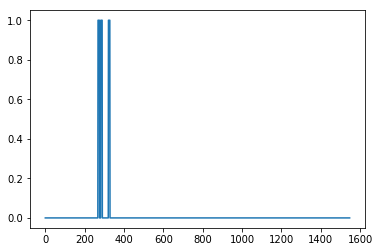

In [638]:
plt.plot(y_train_is_flip_[60])
y_train_is_flip_[60].shape

# 2 - Model

With the data all ready to go, lets move on to the Model

The model will use 1-D convolutional layers, BatchNorm, and a final dense layer. Let's load the packages that will allow you to use these layers in Keras. This might take a minute to load. 

In [1003]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Multiply
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, Permute, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import Flatten, ThresholdedReLU, SimpleRNN, add, concatenate
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.backend import squeeze
from keras import regularizers
import tensorflow as tf
from keras import backend as K

# 2.1 - Build the model



In [846]:
# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    act = 'tanh'
    X= Conv1D(filters = 32, kernel_size = 3, strides =1, activation = act, padding = 'same')(X_input) 
    X = Dropout(.5)(X)
    X = BatchNormalization()(X)
    W = Conv1D(filters = 64, kernel_size = 6, strides =1, activation = act, padding = 'same')(X)
    W = Dropout(.5)(W)
    W = BatchNormalization()(W)
    V = Conv1D(filters = 64, kernel_size = 9, strides =1, activation = act,  padding = 'same')(W)# CONV2D
    V = Dropout(.5)(V)
    V = BatchNormalization()(V)
    U = Conv1D(filters = 64, kernel_size = 15, strides =1, activation = act,  padding = 'same')(V)# CONV2D
    U = Dropout(.5)(U)
    U = BatchNormalization()(U)
    cat= concatenate(([U, V, W]), axis = -1)
    cat = Conv1D(filters = 64, kernel_size = 3, strides =1, activation = act, padding = 'same')(cat)
    cat = Dropout(.4)(cat)
    lstm_out = Conv1D(filters = 1, kernel_size = 10, strides =1, activation = 'sigmoid', padding = 'same', name = 'lstm_out' )(cat)
   
    
    
    act = 'relu'
    X = Conv1D(filters = 64, kernel_size = 35, strides =10, activation = act, padding = 'same')(lstm_out) 
    X = Dropout(.5)(X)
    W = Conv1D(filters = 64, kernel_size = 5, strides =3, activation = act, padding = 'same')(X)
    W = Dropout(.5)(W)
    V = Conv1D(filters = 64, kernel_size = 5, strides =3, activation = act,  padding = 'same')(W)# CONV2D
    V = Dropout(.5)(V)
    V = BatchNormalization()(V)
    cat= concatenate(([V, W, X]), axis = -2)
    Z = Flatten()(X)
    Z = Dense(1, activation = 'relu',name = 'reg_out')(Z)
    
    model = Model(inputs = X_input, outputs = [Z, lstm_out])
    
    return model  

In [ ]:
x,y = X_train_s[0].shape
print(x)
print(y)
model = model(input_shape = (x,y))

Let's print the model summary to keep track of the shapes.

In [1018]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           (None, 1548, 513)    0                                            
__________________________________________________________________________________________________
conv1d_467 (Conv1D)             (None, 1548, 32)     49280       input_58[0][0]                   
__________________________________________________________________________________________________
dropout_430 (Dropout)           (None, 1548, 32)     0           conv1d_467[0][0]                 
__________________________________________________________________________________________________
batch_normalization_279 (BatchN (None, 1548, 32)     128         dropout_430[0][0]                
__________________________________________________________________________________________________
conv1d_468


## 2.2 - Fit the model

In [ ]:
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer= opt,
              loss={'reg_out': 'MSE', 'lstm_out': 'binary_crossentropy'},
              loss_weights={'reg_out': 1., 'lstm_out': 1000}, metrics=["accuracy"])
class_weight = {0: 1.,
                1: 1.}

idx is : 0
Epoch 1/50
960/960 [==============================] - 75s 78ms/step - loss: 262.0771 - reg_out_loss: 3.4286 - lstm_out_loss: 0.2586 - reg_out_acc: 0.2333 - lstm_out_acc: 0.9013
Epoch 2/50
960/960 [==============================] - 56s 59ms/step - loss: 120.8370 - reg_out_loss: 1.4392 - lstm_out_loss: 0.1194 - reg_out_acc: 0.2281 - lstm_out_acc: 0.9767
Epoch 3/50
960/960 [==============================] - 56s 59ms/step - loss: 115.8036 - reg_out_loss: 1.2880 - lstm_out_loss: 0.1145 - reg_out_acc: 0.2573 - lstm_out_acc: 0.9767
Epoch 4/50
960/960 [==============================] - 56s 59ms/step - loss: 114.5786 - reg_out_loss: 1.2741 - lstm_out_loss: 0.1133 - reg_out_acc: 0.2417 - lstm_out_acc: 0.9767
Epoch 5/50
960/960 [==============================] - 57s 59ms/step - loss: 113.9833 - reg_out_loss: 1.3293 - lstm_out_loss: 0.1127 - reg_out_acc: 0.2406 - lstm_out_acc: 0.9767
Epoch 6/50
960/960 [==============================] - 56s 59ms/step - loss: 112.4033 - reg_out_loss: 1.2

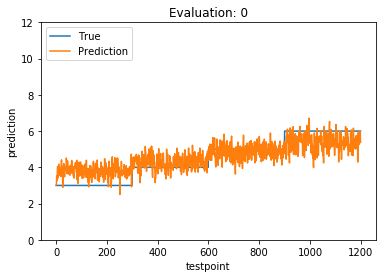

idx is : 1
Epoch 1/50
960/960 [==============================] - 77s 80ms/step - loss: 34.5606 - reg_out_loss: 0.7304 - lstm_out_loss: 0.0338 - reg_out_acc: 0.3990 - lstm_out_acc: 0.9880
Epoch 2/50
960/960 [==============================] - 58s 60ms/step - loss: 35.0606 - reg_out_loss: 0.7376 - lstm_out_loss: 0.0343 - reg_out_acc: 0.3979 - lstm_out_acc: 0.9875
Epoch 3/50
960/960 [==============================] - 57s 60ms/step - loss: 34.5513 - reg_out_loss: 0.7636 - lstm_out_loss: 0.0338 - reg_out_acc: 0.3854 - lstm_out_acc: 0.9878
Epoch 4/50
960/960 [==============================] - 59s 61ms/step - loss: 34.8486 - reg_out_loss: 0.7162 - lstm_out_loss: 0.0341 - reg_out_acc: 0.3906 - lstm_out_acc: 0.9880
Epoch 5/50
960/960 [==============================] - 57s 60ms/step - loss: 33.9530 - reg_out_loss: 0.6766 - lstm_out_loss: 0.0333 - reg_out_acc: 0.4177 - lstm_out_acc: 0.9881
Epoch 6/50
960/960 [==============================] - 57s 60ms/step - loss: 34.6516 - reg_out_loss: 0.7005 - 

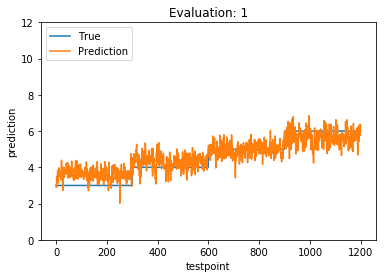

idx is : 2
Epoch 1/50
960/960 [==============================] - 76s 79ms/step - loss: 23.4652 - reg_out_loss: 0.4969 - lstm_out_loss: 0.0230 - reg_out_acc: 0.5229 - lstm_out_acc: 0.9915
Epoch 2/50
960/960 [==============================] - 57s 60ms/step - loss: 22.9112 - reg_out_loss: 0.4780 - lstm_out_loss: 0.0224 - reg_out_acc: 0.5375 - lstm_out_acc: 0.9918
Epoch 3/50
960/960 [==============================] - 57s 60ms/step - loss: 23.1498 - reg_out_loss: 0.4486 - lstm_out_loss: 0.0227 - reg_out_acc: 0.5208 - lstm_out_acc: 0.9918
Epoch 4/50
960/960 [==============================] - 57s 60ms/step - loss: 22.7049 - reg_out_loss: 0.4782 - lstm_out_loss: 0.0222 - reg_out_acc: 0.5062 - lstm_out_acc: 0.9920
Epoch 5/50
960/960 [==============================] - 57s 60ms/step - loss: 22.9070 - reg_out_loss: 0.4840 - lstm_out_loss: 0.0224 - reg_out_acc: 0.5198 - lstm_out_acc: 0.9919
Epoch 6/50
960/960 [==============================] - 58s 61ms/step - loss: 23.2965 - reg_out_loss: 0.4969 - 

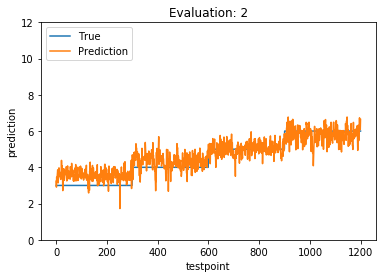

idx is : 3
Epoch 1/50
960/960 [==============================] - 75s 78ms/step - loss: 20.8433 - reg_out_loss: 0.4362 - lstm_out_loss: 0.0204 - reg_out_acc: 0.5542 - lstm_out_acc: 0.9925
Epoch 2/50
960/960 [==============================] - 58s 60ms/step - loss: 21.0117 - reg_out_loss: 0.4332 - lstm_out_loss: 0.0206 - reg_out_acc: 0.5281 - lstm_out_acc: 0.9923
Epoch 3/50
960/960 [==============================] - 58s 60ms/step - loss: 20.8668 - reg_out_loss: 0.4353 - lstm_out_loss: 0.0204 - reg_out_acc: 0.5531 - lstm_out_acc: 0.9925
Epoch 4/50
960/960 [==============================] - 58s 60ms/step - loss: 21.4515 - reg_out_loss: 0.4494 - lstm_out_loss: 0.0210 - reg_out_acc: 0.5365 - lstm_out_acc: 0.9922
Epoch 5/50
960/960 [==============================] - 58s 60ms/step - loss: 20.8789 - reg_out_loss: 0.4663 - lstm_out_loss: 0.0204 - reg_out_acc: 0.5438 - lstm_out_acc: 0.9926
Epoch 6/50
960/960 [==============================] - 58s 60ms/step - loss: 20.9461 - reg_out_loss: 0.4466 - 

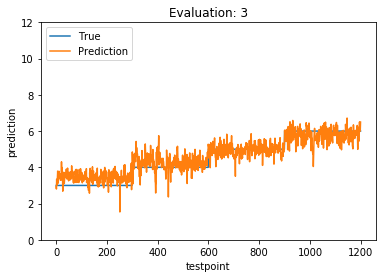

idx is : 4
Epoch 1/50
960/960 [==============================] - 76s 79ms/step - loss: 17.9837 - reg_out_loss: 0.3954 - lstm_out_loss: 0.0176 - reg_out_acc: 0.5625 - lstm_out_acc: 0.9937
Epoch 2/50
960/960 [==============================] - 59s 61ms/step - loss: 17.7715 - reg_out_loss: 0.3696 - lstm_out_loss: 0.0174 - reg_out_acc: 0.5865 - lstm_out_acc: 0.9937
Epoch 3/50
960/960 [==============================] - 57s 60ms/step - loss: 17.9109 - reg_out_loss: 0.3677 - lstm_out_loss: 0.0175 - reg_out_acc: 0.5979 - lstm_out_acc: 0.9938
Epoch 4/50
960/960 [==============================] - 58s 60ms/step - loss: 18.0101 - reg_out_loss: 0.3630 - lstm_out_loss: 0.0176 - reg_out_acc: 0.5854 - lstm_out_acc: 0.9937
Epoch 5/50
960/960 [==============================] - 58s 60ms/step - loss: 17.6604 - reg_out_loss: 0.3629 - lstm_out_loss: 0.0173 - reg_out_acc: 0.5875 - lstm_out_acc: 0.9938
Epoch 6/50
960/960 [==============================] - 57s 60ms/step - loss: 17.8165 - reg_out_loss: 0.3661 - 

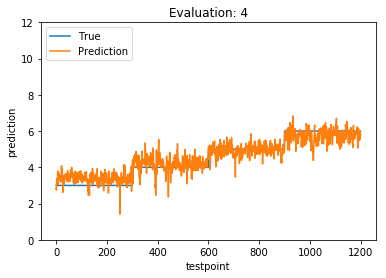

idx is : 5
Epoch 1/50
960/960 [==============================] - 80s 84ms/step - loss: 16.4232 - reg_out_loss: 0.3582 - lstm_out_loss: 0.0161 - reg_out_acc: 0.6135 - lstm_out_acc: 0.9942
Epoch 2/50
960/960 [==============================] - 73s 76ms/step - loss: 16.3410 - reg_out_loss: 0.3434 - lstm_out_loss: 0.0160 - reg_out_acc: 0.6073 - lstm_out_acc: 0.9942
Epoch 3/50
960/960 [==============================] - 67s 70ms/step - loss: 16.2479 - reg_out_loss: 0.3241 - lstm_out_loss: 0.0159 - reg_out_acc: 0.6271 - lstm_out_acc: 0.9943
Epoch 4/50
960/960 [==============================] - 62s 65ms/step - loss: 15.9707 - reg_out_loss: 0.3218 - lstm_out_loss: 0.0156 - reg_out_acc: 0.6312 - lstm_out_acc: 0.9944
Epoch 5/50
960/960 [==============================] - 62s 65ms/step - loss: 16.2099 - reg_out_loss: 0.3290 - lstm_out_loss: 0.0159 - reg_out_acc: 0.6417 - lstm_out_acc: 0.9943
Epoch 6/50
960/960 [==============================] - 66s 69ms/step - loss: 16.2573 - reg_out_loss: 0.3315 - 

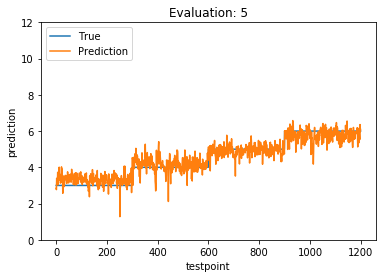

idx is : 6
Epoch 1/50
960/960 [==============================] - 74s 77ms/step - loss: 14.2543 - reg_out_loss: 0.2765 - lstm_out_loss: 0.0140 - reg_out_acc: 0.6844 - lstm_out_acc: 0.9951
Epoch 2/50
960/960 [==============================] - 58s 61ms/step - loss: 14.0234 - reg_out_loss: 0.2644 - lstm_out_loss: 0.0138 - reg_out_acc: 0.6781 - lstm_out_acc: 0.9951
Epoch 3/50
960/960 [==============================] - 58s 61ms/step - loss: 14.1271 - reg_out_loss: 0.2998 - lstm_out_loss: 0.0138 - reg_out_acc: 0.6594 - lstm_out_acc: 0.9951
Epoch 4/50
960/960 [==============================] - 58s 61ms/step - loss: 13.9971 - reg_out_loss: 0.2848 - lstm_out_loss: 0.0137 - reg_out_acc: 0.6729 - lstm_out_acc: 0.9952
Epoch 5/50
960/960 [==============================] - 58s 61ms/step - loss: 13.7735 - reg_out_loss: 0.2962 - lstm_out_loss: 0.0135 - reg_out_acc: 0.6469 - lstm_out_acc: 0.9953
Epoch 6/50
960/960 [==============================] - 60s 62ms/step - loss: 14.1610 - reg_out_loss: 0.2757 - 

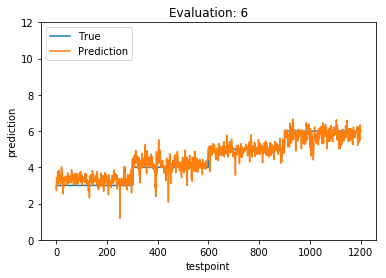

idx is : 7
Epoch 1/50
960/960 [==============================] - 74s 77ms/step - loss: 12.6374 - reg_out_loss: 0.2581 - lstm_out_loss: 0.0124 - reg_out_acc: 0.6990 - lstm_out_acc: 0.9958
Epoch 2/50
960/960 [==============================] - 58s 60ms/step - loss: 12.7921 - reg_out_loss: 0.2545 - lstm_out_loss: 0.0125 - reg_out_acc: 0.7146 - lstm_out_acc: 0.9957
Epoch 3/50
960/960 [==============================] - 59s 62ms/step - loss: 12.7006 - reg_out_loss: 0.2589 - lstm_out_loss: 0.0124 - reg_out_acc: 0.7240 - lstm_out_acc: 0.9957
Epoch 4/50
960/960 [==============================] - 57s 59ms/step - loss: 12.6474 - reg_out_loss: 0.2459 - lstm_out_loss: 0.0124 - reg_out_acc: 0.7042 - lstm_out_acc: 0.9958
Epoch 5/50
960/960 [==============================] - 57s 59ms/step - loss: 12.6215 - reg_out_loss: 0.2427 - lstm_out_loss: 0.0124 - reg_out_acc: 0.6958 - lstm_out_acc: 0.9958
Epoch 6/50
960/960 [==============================] - 57s 59ms/step - loss: 12.6831 - reg_out_loss: 0.2372 - 

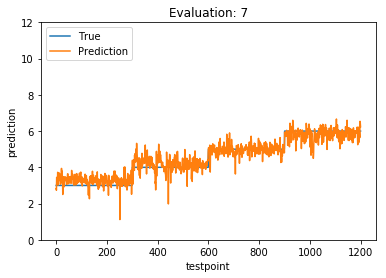

idx is : 8
Epoch 1/50
960/960 [==============================] - 77s 80ms/step - loss: 12.3725 - reg_out_loss: 0.2648 - lstm_out_loss: 0.0121 - reg_out_acc: 0.6750 - lstm_out_acc: 0.9960
Epoch 2/50
960/960 [==============================] - 59s 61ms/step - loss: 12.0121 - reg_out_loss: 0.2449 - lstm_out_loss: 0.0118 - reg_out_acc: 0.7177 - lstm_out_acc: 0.9960
Epoch 3/50
960/960 [==============================] - 58s 61ms/step - loss: 12.1996 - reg_out_loss: 0.2376 - lstm_out_loss: 0.0120 - reg_out_acc: 0.7177 - lstm_out_acc: 0.9961
Epoch 4/50
960/960 [==============================] - 60s 62ms/step - loss: 12.0952 - reg_out_loss: 0.2540 - lstm_out_loss: 0.0118 - reg_out_acc: 0.7062 - lstm_out_acc: 0.9960
Epoch 5/50
960/960 [==============================] - 58s 60ms/step - loss: 12.3561 - reg_out_loss: 0.2535 - lstm_out_loss: 0.0121 - reg_out_acc: 0.7156 - lstm_out_acc: 0.9961
Epoch 6/50
960/960 [==============================] - 58s 60ms/step - loss: 12.1522 - reg_out_loss: 0.2390 - 

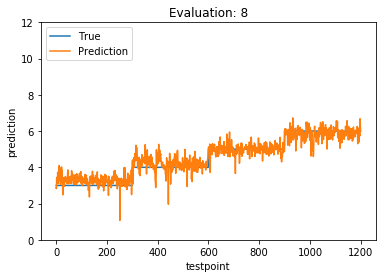

idx is : 9
Epoch 1/50
960/960 [==============================] - 82s 85ms/step - loss: 11.5354 - reg_out_loss: 0.2291 - lstm_out_loss: 0.0113 - reg_out_acc: 0.7354 - lstm_out_acc: 0.9963
Epoch 2/50
960/960 [==============================] - 74s 77ms/step - loss: 11.6198 - reg_out_loss: 0.2337 - lstm_out_loss: 0.0114 - reg_out_acc: 0.7177 - lstm_out_acc: 0.9963
Epoch 3/50
960/960 [==============================] - 85s 88ms/step - loss: 11.7731 - reg_out_loss: 0.2179 - lstm_out_loss: 0.0116 - reg_out_acc: 0.7552 - lstm_out_acc: 0.9962
Epoch 4/50
960/960 [==============================] - 67s 69ms/step - loss: 11.6864 - reg_out_loss: 0.2310 - lstm_out_loss: 0.0115 - reg_out_acc: 0.7354 - lstm_out_acc: 0.9963
Epoch 5/50
960/960 [==============================] - 87s 91ms/step - loss: 11.5877 - reg_out_loss: 0.2307 - lstm_out_loss: 0.0114 - reg_out_acc: 0.7271 - lstm_out_acc: 0.9963
Epoch 6/50
960/960 [==============================] - 91s 95ms/step - loss: 11.5880 - reg_out_loss: 0.2146 - 

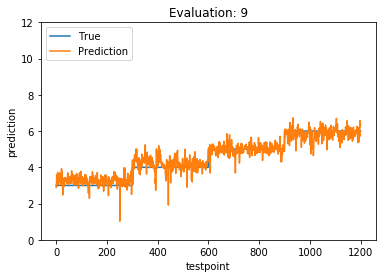

idx is : 10
Epoch 1/50
960/960 [==============================] - 96s 100ms/step - loss: 11.1953 - reg_out_loss: 0.2080 - lstm_out_loss: 0.0110 - reg_out_acc: 0.7531 - lstm_out_acc: 0.9964
Epoch 2/50
960/960 [==============================] - 76s 79ms/step - loss: 11.0696 - reg_out_loss: 0.2318 - lstm_out_loss: 0.0108 - reg_out_acc: 0.7219 - lstm_out_acc: 0.9965
Epoch 3/50
960/960 [==============================] - 61s 64ms/step - loss: 11.2105 - reg_out_loss: 0.2068 - lstm_out_loss: 0.0110 - reg_out_acc: 0.7625 - lstm_out_acc: 0.9965
Epoch 4/50
960/960 [==============================] - 69s 72ms/step - loss: 11.0311 - reg_out_loss: 0.2106 - lstm_out_loss: 0.0108 - reg_out_acc: 0.7677 - lstm_out_acc: 0.9965
Epoch 5/50
960/960 [==============================] - 80s 83ms/step - loss: 11.4722 - reg_out_loss: 0.2363 - lstm_out_loss: 0.0112 - reg_out_acc: 0.7135 - lstm_out_acc: 0.9963
Epoch 6/50
960/960 [==============================] - 63s 66ms/step - loss: 11.1318 - reg_out_loss: 0.2267 

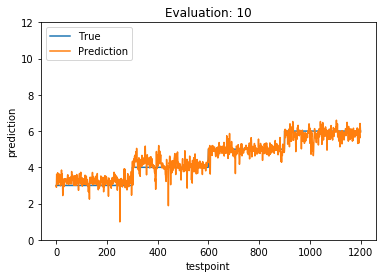

idx is : 11
Epoch 1/50
960/960 [==============================] - 76s 79ms/step - loss: 10.9538 - reg_out_loss: 0.2172 - lstm_out_loss: 0.0107 - reg_out_acc: 0.7448 - lstm_out_acc: 0.9965
Epoch 2/50
960/960 [==============================] - 59s 61ms/step - loss: 10.6125 - reg_out_loss: 0.1940 - lstm_out_loss: 0.0104 - reg_out_acc: 0.7792 - lstm_out_acc: 0.9966
Epoch 3/50
960/960 [==============================] - 57s 59ms/step - loss: 10.7584 - reg_out_loss: 0.2147 - lstm_out_loss: 0.0105 - reg_out_acc: 0.7406 - lstm_out_acc: 0.9966
Epoch 4/50
960/960 [==============================] - 56s 58ms/step - loss: 10.7895 - reg_out_loss: 0.2112 - lstm_out_loss: 0.0106 - reg_out_acc: 0.7500 - lstm_out_acc: 0.9966
Epoch 5/50
960/960 [==============================] - 57s 60ms/step - loss: 10.9529 - reg_out_loss: 0.2118 - lstm_out_loss: 0.0107 - reg_out_acc: 0.7500 - lstm_out_acc: 0.9965
Epoch 6/50
960/960 [==============================] - 59s 61ms/step - loss: 10.8556 - reg_out_loss: 0.2092 -

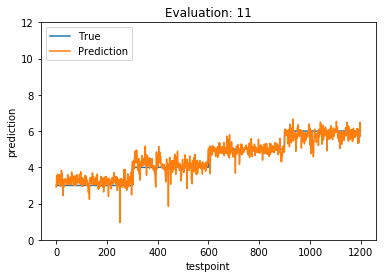

idx is : 12
Epoch 1/50
960/960 [==============================] - 82s 85ms/step - loss: 10.8858 - reg_out_loss: 0.2230 - lstm_out_loss: 0.0107 - reg_out_acc: 0.7677 - lstm_out_acc: 0.9966
Epoch 2/50
960/960 [==============================] - 58s 60ms/step - loss: 10.7494 - reg_out_loss: 0.2161 - lstm_out_loss: 0.0105 - reg_out_acc: 0.7417 - lstm_out_acc: 0.9966
Epoch 3/50
960/960 [==============================] - 57s 60ms/step - loss: 10.7109 - reg_out_loss: 0.2038 - lstm_out_loss: 0.0105 - reg_out_acc: 0.7604 - lstm_out_acc: 0.9967
Epoch 4/50
960/960 [==============================] - 57s 60ms/step - loss: 10.7099 - reg_out_loss: 0.2126 - lstm_out_loss: 0.0105 - reg_out_acc: 0.7521 - lstm_out_acc: 0.9966
Epoch 5/50
960/960 [==============================] - 57s 59ms/step - loss: 10.6515 - reg_out_loss: 0.2175 - lstm_out_loss: 0.0104 - reg_out_acc: 0.7573 - lstm_out_acc: 0.9966
Epoch 6/50
960/960 [==============================] - 57s 59ms/step - loss: 10.5023 - reg_out_loss: 0.2072 -

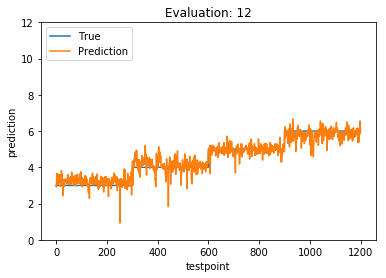

idx is : 13
Epoch 1/50
960/960 [==============================] - 78s 81ms/step - loss: 10.2884 - reg_out_loss: 0.1906 - lstm_out_loss: 0.0101 - reg_out_acc: 0.7760 - lstm_out_acc: 0.9968
Epoch 2/50
960/960 [==============================] - 59s 61ms/step - loss: 10.1856 - reg_out_loss: 0.2071 - lstm_out_loss: 0.0100 - reg_out_acc: 0.7562 - lstm_out_acc: 0.9968
Epoch 3/50
960/960 [==============================] - 58s 61ms/step - loss: 10.0060 - reg_out_loss: 0.2060 - lstm_out_loss: 0.0098 - reg_out_acc: 0.7625 - lstm_out_acc: 0.9968
Epoch 4/50
960/960 [==============================] - 58s 60ms/step - loss: 10.3100 - reg_out_loss: 0.2107 - lstm_out_loss: 0.0101 - reg_out_acc: 0.7677 - lstm_out_acc: 0.9967
Epoch 5/50
960/960 [==============================] - 58s 60ms/step - loss: 10.2798 - reg_out_loss: 0.2016 - lstm_out_loss: 0.0101 - reg_out_acc: 0.7615 - lstm_out_acc: 0.9967
Epoch 6/50
960/960 [==============================] - 58s 60ms/step - loss: 10.4892 - reg_out_loss: 0.2139 -

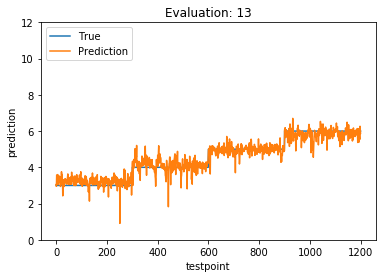

idx is : 14
Epoch 1/50
960/960 [==============================] - 79s 82ms/step - loss: 9.9711 - reg_out_loss: 0.1986 - lstm_out_loss: 0.0098 - reg_out_acc: 0.7656 - lstm_out_acc: 0.9969
Epoch 2/50
960/960 [==============================] - 60s 63ms/step - loss: 10.1610 - reg_out_loss: 0.2126 - lstm_out_loss: 0.0099 - reg_out_acc: 0.7469 - lstm_out_acc: 0.9969
Epoch 3/50
960/960 [==============================] - 57s 59ms/step - loss: 9.9174 - reg_out_loss: 0.2063 - lstm_out_loss: 0.0097 - reg_out_acc: 0.7521 - lstm_out_acc: 0.9969
Epoch 4/50
960/960 [==============================] - 57s 60ms/step - loss: 10.0007 - reg_out_loss: 0.2011 - lstm_out_loss: 0.0098 - reg_out_acc: 0.7865 - lstm_out_acc: 0.9968
Epoch 5/50
960/960 [==============================] - 56s 59ms/step - loss: 10.0833 - reg_out_loss: 0.1997 - lstm_out_loss: 0.0099 - reg_out_acc: 0.7604 - lstm_out_acc: 0.9969
Epoch 6/50
960/960 [==============================] - 57s 59ms/step - loss: 9.9675 - reg_out_loss: 0.1941 - ls

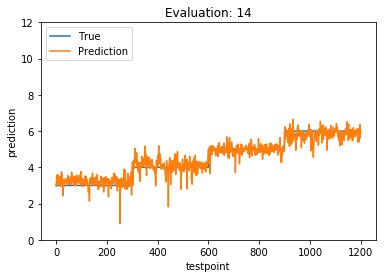

idx is : 15
Epoch 1/50
960/960 [==============================] - 79s 82ms/step - loss: 9.9808 - reg_out_loss: 0.2039 - lstm_out_loss: 0.0098 - reg_out_acc: 0.7625 - lstm_out_acc: 0.9969
Epoch 2/50
960/960 [==============================] - 61s 63ms/step - loss: 10.0050 - reg_out_loss: 0.1881 - lstm_out_loss: 0.0098 - reg_out_acc: 0.7635 - lstm_out_acc: 0.9969
Epoch 3/50
960/960 [==============================] - 58s 60ms/step - loss: 9.8278 - reg_out_loss: 0.2055 - lstm_out_loss: 0.0096 - reg_out_acc: 0.7562 - lstm_out_acc: 0.9969
Epoch 4/50
960/960 [==============================] - 58s 60ms/step - loss: 9.9508 - reg_out_loss: 0.1945 - lstm_out_loss: 0.0098 - reg_out_acc: 0.7729 - lstm_out_acc: 0.9968
Epoch 5/50
960/960 [==============================] - 57s 60ms/step - loss: 10.0662 - reg_out_loss: 0.1960 - lstm_out_loss: 0.0099 - reg_out_acc: 0.7833 - lstm_out_acc: 0.9968
Epoch 6/50
960/960 [==============================] - 57s 59ms/step - loss: 9.9742 - reg_out_loss: 0.1769 - lst

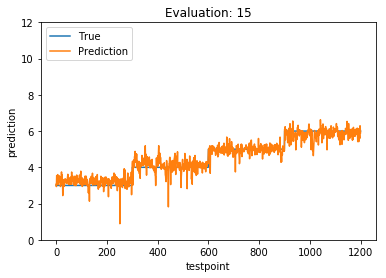

idx is : 16
Epoch 1/50
960/960 [==============================] - 79s 82ms/step - loss: 9.8494 - reg_out_loss: 0.1950 - lstm_out_loss: 0.0097 - reg_out_acc: 0.7740 - lstm_out_acc: 0.9970
Epoch 2/50
960/960 [==============================] - 60s 63ms/step - loss: 9.8664 - reg_out_loss: 0.1786 - lstm_out_loss: 0.0097 - reg_out_acc: 0.7990 - lstm_out_acc: 0.9970
Epoch 3/50
960/960 [==============================] - 58s 60ms/step - loss: 9.8857 - reg_out_loss: 0.2006 - lstm_out_loss: 0.0097 - reg_out_acc: 0.7865 - lstm_out_acc: 0.9969
Epoch 4/50
960/960 [==============================] - 57s 60ms/step - loss: 9.7739 - reg_out_loss: 0.1860 - lstm_out_loss: 0.0096 - reg_out_acc: 0.8000 - lstm_out_acc: 0.9969
Epoch 5/50
960/960 [==============================] - 57s 59ms/step - loss: 9.6870 - reg_out_loss: 0.1858 - lstm_out_loss: 0.0095 - reg_out_acc: 0.7823 - lstm_out_acc: 0.9970
Epoch 6/50
960/960 [==============================] - 57s 59ms/step - loss: 9.7226 - reg_out_loss: 0.1880 - lstm_

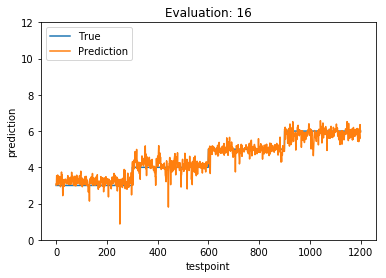

idx is : 17
Epoch 1/50
960/960 [==============================] - 79s 82ms/step - loss: 9.4361 - reg_out_loss: 0.1846 - lstm_out_loss: 0.0093 - reg_out_acc: 0.7844 - lstm_out_acc: 0.9971
Epoch 2/50
960/960 [==============================] - 59s 61ms/step - loss: 9.5639 - reg_out_loss: 0.1846 - lstm_out_loss: 0.0094 - reg_out_acc: 0.7833 - lstm_out_acc: 0.9971
Epoch 3/50
960/960 [==============================] - 58s 61ms/step - loss: 9.5994 - reg_out_loss: 0.1804 - lstm_out_loss: 0.0094 - reg_out_acc: 0.8063 - lstm_out_acc: 0.9970
Epoch 4/50
960/960 [==============================] - 57s 60ms/step - loss: 9.5965 - reg_out_loss: 0.1802 - lstm_out_loss: 0.0094 - reg_out_acc: 0.7927 - lstm_out_acc: 0.9970
Epoch 5/50
960/960 [==============================] - 57s 59ms/step - loss: 9.6578 - reg_out_loss: 0.1869 - lstm_out_loss: 0.0095 - reg_out_acc: 0.7896 - lstm_out_acc: 0.9970
Epoch 6/50
960/960 [==============================] - 57s 60ms/step - loss: 9.7652 - reg_out_loss: 0.1988 - lstm_

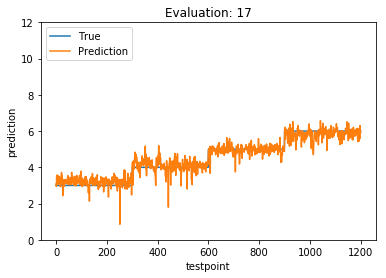

idx is : 18
Epoch 1/50
960/960 [==============================] - 81s 84ms/step - loss: 9.5467 - reg_out_loss: 0.1910 - lstm_out_loss: 0.0094 - reg_out_acc: 0.7802 - lstm_out_acc: 0.9970
Epoch 2/50
960/960 [==============================] - 58s 61ms/step - loss: 9.6054 - reg_out_loss: 0.1832 - lstm_out_loss: 0.0094 - reg_out_acc: 0.7990 - lstm_out_acc: 0.9970
Epoch 3/50
960/960 [==============================] - 59s 62ms/step - loss: 9.3856 - reg_out_loss: 0.1860 - lstm_out_loss: 0.0092 - reg_out_acc: 0.7792 - lstm_out_acc: 0.9971
Epoch 4/50
960/960 [==============================] - 58s 61ms/step - loss: 9.5689 - reg_out_loss: 0.1937 - lstm_out_loss: 0.0094 - reg_out_acc: 0.7833 - lstm_out_acc: 0.9970
Epoch 5/50
960/960 [==============================] - 57s 60ms/step - loss: 9.6638 - reg_out_loss: 0.1977 - lstm_out_loss: 0.0095 - reg_out_acc: 0.7615 - lstm_out_acc: 0.9970
Epoch 6/50
960/960 [==============================] - 60s 63ms/step - loss: 9.5319 - reg_out_loss: 0.1873 - lstm_

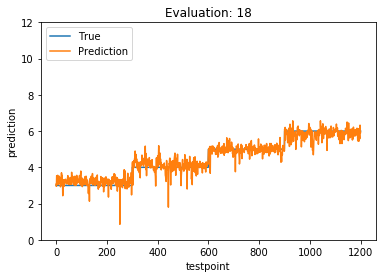

idx is : 19
Epoch 1/50
960/960 [==============================] - 78s 81ms/step - loss: 9.4969 - reg_out_loss: 0.1918 - lstm_out_loss: 0.0093 - reg_out_acc: 0.8000 - lstm_out_acc: 0.9970
Epoch 2/50
960/960 [==============================] - 59s 61ms/step - loss: 9.5000 - reg_out_loss: 0.1769 - lstm_out_loss: 0.0093 - reg_out_acc: 0.8094 - lstm_out_acc: 0.9970
Epoch 3/50
960/960 [==============================] - 57s 60ms/step - loss: 9.6149 - reg_out_loss: 0.1900 - lstm_out_loss: 0.0094 - reg_out_acc: 0.7792 - lstm_out_acc: 0.9970
Epoch 4/50
960/960 [==============================] - 57s 59ms/step - loss: 9.4378 - reg_out_loss: 0.1770 - lstm_out_loss: 0.0093 - reg_out_acc: 0.7969 - lstm_out_acc: 0.9971
Epoch 5/50
960/960 [==============================] - 57s 60ms/step - loss: 9.4428 - reg_out_loss: 0.1748 - lstm_out_loss: 0.0093 - reg_out_acc: 0.8021 - lstm_out_acc: 0.9970
Epoch 6/50
960/960 [==============================] - 57s 59ms/step - loss: 9.3046 - reg_out_loss: 0.1784 - lstm_

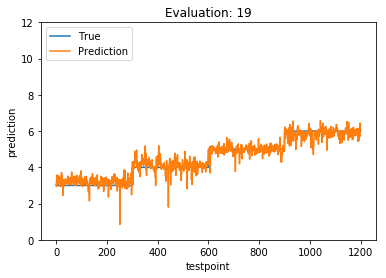

idx is : 20
Epoch 1/50
 80/960 [=>............................] - ETA: 1:26 - loss: 10.7421 - reg_out_loss: 0.2339 - lstm_out_loss: 0.0105 - reg_out_acc: 0.7000 - lstm_out_acc: 0.9965

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [850]:
img_list_ev = []
img_list_loss = []
loss_history = np.zeros(0)
dev_set_acc = np.zeros(0)
max_val_acc = 0
for idx in range(800):
    print("idx is : " + str(idx))
    
    history = model.fit(X_train_s, {'reg_out': y_train_regression, 'lstm_out': y_train_is_flip}, batch_size = 16, epochs=50, class_weight = class_weight)
    evaluation = model.predict(train_X_spec)
    loss = model.evaluate(X_test_s, {'reg_out': y_test_regression, 'lstm_out': y_test_is_flip})
    acc = loss[3] # happens to be reg out accuracy
    
    if acc > max_val_acc:
        max_val_acc = acc
    print("Dev set accuracy = ", acc)
    print("max validation acc = ", max_val_acc)
    plt.plot(train_y_spec)
    plt.plot(evaluation[0])
    plt.title('Evaluation: ' + str(idx))
    plt.ylabel('prediction')
    plt.xlabel('testpoint')
    axes = plt.gca()
    axes.set_ylim([0,12])
    plt.legend(['True', 'Prediction'], loc='upper left')
    plt.savefig('temp_img.png')
    img_list_ev.append(imageio.imread('temp_img.png'))
    plt.show()
    plt.clf()
    
    loss_history = np.append(loss_history,history.history['loss'])


## 2.3 Debug Model 
The model predicts both a binary time series of predictions if any time slice of the spectrogram is a card flip.  A plot of that output gives a good visualization of what and where anything may go wrong and plotting the actual input that the model receives can help see problems

true : 4.0
pred : 3.9988492


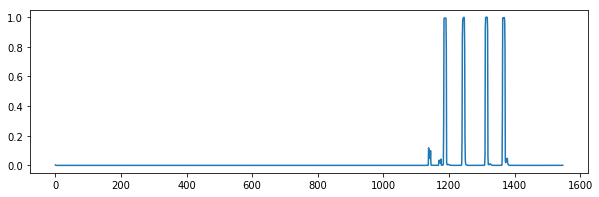

<Figure size 432x288 with 0 Axes>

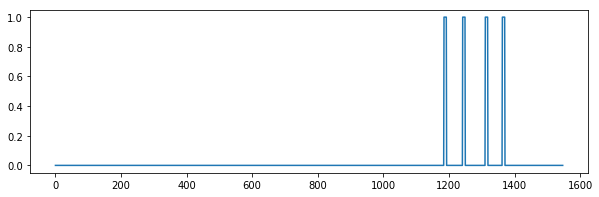

In [1014]:
tp= tp+1
evalu = model.predict(train_X_spec[tp:tp+1,:,:])
pl = np.zeros(len(train_X_spec[0]))
for i in range(len(evalu[1][0])):
    pl[i] = evalu[1][0][i]

print('true : ' + str(train_y_spec[tp]))
print('pred : ' + str(evalu[0][0][0]))
plt.figure(figsize=(10,3))
plt.plot(pl)
plt.figure(2)
plt.figure(figsize=(10,3))
plt.plot(train_y_anno[tp])

In [1015]:
tp  

318

318


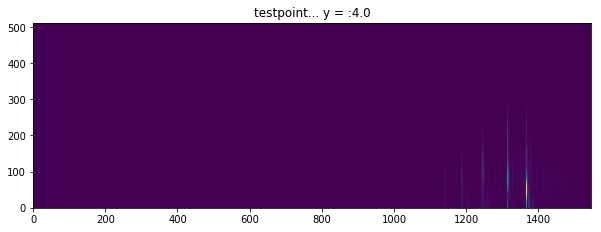

In [1016]:
print(tp)
pic = train_X_spec[tp].swapaxes(-2,-1) # i need to swap axis so i looks the way i expect
plt.figure(figsize=(10,5))
plt.title('testpoint...'+ ' y = :' + str(train_y_spec[tp]))
plt.imshow(pic)
plt.xlim(0, 1546)
plt.gca().invert_yaxis()

## 2.4 Loss visualization

Text(0, 0.5, 'Loss')

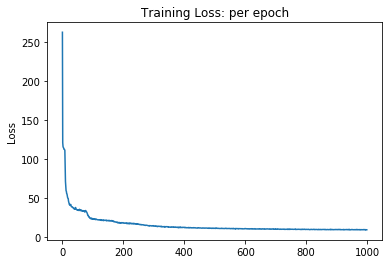

In [1017]:
plt.plot(loss_history)
plt.title('Training Loss: per epoch')
plt.ylabel('Loss')

## 2.5 Visualize Training

Stitching screenshots of predicted output graphs helps visualize the training

In [1000]:
imageio.mimsave('training_mov45.gif', img_list_ev,fps = 24)
print(len(img_list_ev))

20


![](training_mov45.gif)

In [1019]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('conv1d_467').output)
intermediate_output = intermediate_layer_model.predict(X_test_s)

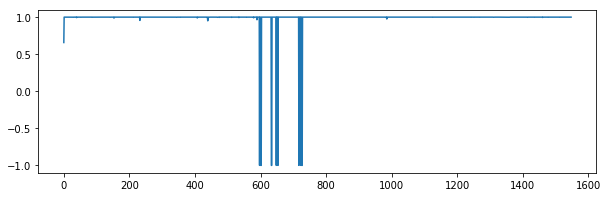

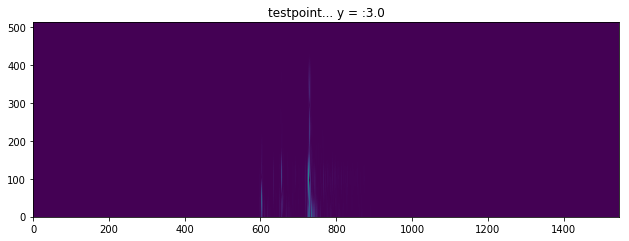

In [1060]:
tp = tp+1
filter_ = 0
intermediate_output.shape
plt.figure(figsize=(10,3))
plt.plot(intermediate_output[tp,:,filter_])
plt.figure(1)
pic = X_test_s[tp].swapaxes(-2,-1) # i need to swap axis so i looks the way i expect
plt.figure(figsize=(10.5,5))
plt.title('testpoint...'+ ' y = :' + str(train_y_spec[tp]))
plt.imshow(pic)
plt.xlim(0, 1546)
plt.gca().invert_yaxis()

# Save and recover model

In [973]:
#save model
model.save('model_v02.h5')  # creates a HDF5 file 'my_model.h5'
#recover model
#model = load_model('model_v02.h5')

## 2.3 - Test the model

Finally, let's see how your model performs on the dev set.

In [1002]:
print('Target accuracy is 0.8000 Percent')
loss = model.evaluate(X_test_s, {'reg_out': y_test_regression, 'lstm_out': y_test_is_flip})
print("Dev set accuracy = ", loss[3])
if(loss[3] > .8):
    print('Target accuracy reached!')
else:
    print('Target not attained yet')

Target accuracy is 0.8000 Percent
240/240 [==============================] - 6s 24ms/step
Dev set accuracy =  0.8166666666666667
Target accuracy reached!


len(train_X): 240
len(train_y): 240
1000
final_test_X.shape(420, 1548, 513)


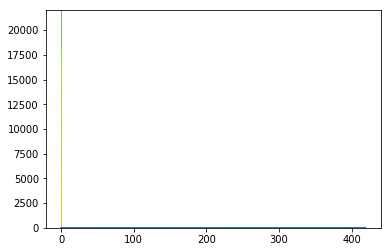

In [1009]:
##Load files
start_training_cflips = 3
max_training_cflips = 10
final_test_X = []
final_test_y = []
letters_idx = ['d'] 

for idx in range(start_training_cflips, max_training_cflips+1, 1):
    for letter in letters_idx:
        buffer, file_found = load_card_flip_raw_audio__simplified_from_index(letter, idx)
        if(file_found):
            final_test_X.extend(buffer)
            y = np.ones(len(buffer))*idx
            final_test_y = np.append(final_test_y, y)
#sanity checks
print("len(train_X): " + str(len(pd_train_X)))
print("len(train_y): " + str(len(pd_train_y)))
plt.plot(final_test_y)
print(len(final_test_X[0]))

## convert to spectrogram
final_test_X, final_test_y = convert_to_spec_set(final_test_X, final_test_y)
print('final_test_X.shape' + str(final_test_X.shape))

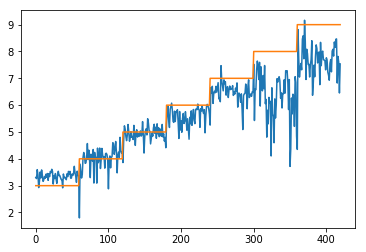

In [1013]:
evaluation = model.predict(final_test_X)
plt.plot(evaluation[0])
plt.plot(final_test_y)

# Conclusions
* Counting Cards from Audio is a non-trivial exercice; however, one that I believe could be done well given eng time
* The model performs well on count #'s it was trained on, but appears to struggle on new larger data
* The reality is a deck of cards can easily pass two cards at once which is indistinguishable to a single card, this is a major source of random error, for the learning algorithm to detect that event, I think much more data would be needed, or the problem would have to be addressed specifically.
* A discovery of concatenating over differing course filters proved to be a personal discovery which appears to have been first used and popularized by [2015 CVPR] [FCN] Fully Convolutional Networks for Semantic Segmentation



# Future Work

* Add in data augmentation of everyday sounds post annotation to learn to reject non-card flip sounds
* Increase overall evaluation on larger decks of cards
* Build iphone app that encapsulates the trained model



# Card Counting Detector Bot (CCDB) Journel 

This has been a very insightful journey
Let this serve as a reminder and encouragement for the future

* 3/20/19 Finished final coursera course
* shortly thereafter started CCDB
* Immediately realized the need for data
* experieced the pain of collecting data, and pivoted to speed up the process programatically
* Datacollection
* 4/23/19 Failure using GRU based models, unable to get a COUNT output
* 5/15/19 Started my toy problem series to just get a simplest solution working
* 5/16/19 This caused a torrent of aha moments, 
    * created a counting solution with non-trainable dense layer
    * improved np array work
    * learned generalizations by both random and quadrant test sets
    * first success with all pieces of ML (data, model, train, eval)...confidence
    * utilized plt.plot for visualization
* 5/17/19 Utilized one-hot representation for toy problem
* 5/18/19 Conv2D used for perfect accuracy
    * easy manipulation of training volume, size to feedback some ML intuitions
* 5/23/19 Conv1D used for perfect accuracy, ready to tackle CCDB again
* 5/27/19 Solved a counting issue by using "thresholdRelu(.99)"
* 5/27/19 Spectrogram research
    * learned gifing my figures for a video based understanding 
    * started doubting the preprocessing as being true to learn from
    * learned various FFT meanings
* 5/30/19 switched to waveform inputs (not spectrogram inputs)
* 6/02/19 Started to see progress on various models (~20%)
* 6/04/19 Started to overfit on data! 
* 6/06/19 moved to a split train/test to get better idea of generalization
    
* 6/21/19 Completed a toy LSTM problem, show unpromising results
* 6/25/19 Resampled dataset with smaller more managable deck sizes, faster training, etc.
    * this resized the problem to be much easier to approach
    * also I could visualize the inputs and easily determine if i'd made a mistake in the recording
    
* 7/01/19 Reading papers, I concluded that I would need more than single output end to end training.
* 7/08/19 Discovered a breakthrough in concatenating layers
* 7/09/19 Implemented to dual loss model
    * this was key to understanding where to focus my efforts
    * this also allowed the model a gentle guidance on how to understand the data
* 7/10/19 Saw impressive results with new architecture after only a few epochs (.400 to .600)
* 7/16/19 Overnight the test training exceeded target of .8!


In [983]:
    """X_input = Input(shape = input_shape)
    
    act = 'tanh'
    X= Conv1D(filters = 32, kernel_size = 3, strides =1, activation = act, padding = 'same')(X_input) 
    X = Dropout(.5)(X)
    X = BatchNormalization()(X)
    W = Conv1D(filters = 64, kernel_size = 6, strides =1, activation = act, padding = 'same')(X)
    W = Dropout(.5)(W)
    W = BatchNormalization()(W)
    V = Conv1D(filters = 64, kernel_size = 9, strides =1, activation = act,  padding = 'same')(W)# CONV2D
    V = Dropout(.5)(V)
    V = BatchNormalization()(V)
    U = Conv1D(filters = 64, kernel_size = 15, strides =1, activation = act,  padding = 'same')(V)# CONV2D
    U = Dropout(.5)(U)
    U = BatchNormalization()(U)
    cat= concatenate(([U, V, W]), axis = -1)
    cat = Conv1D(filters = 64, kernel_size = 3, strides =1, activation = act, padding = 'same')(cat)
    cat = Dropout(.4)(cat)
    lstm_out = Conv1D(filters = 1, kernel_size = 10, strides =1, activation = 'sigmoid', padding = 'same', name = 'lstm_out' )(cat)
    act = 'relu'
    X = Conv1D(filters = 64, kernel_size = 35, strides =10, activation = act, padding = 'same')(lstm_out) 
    X = Dropout(.5)(X)
    W = Conv1D(filters = 64, kernel_size = 5, strides =3, activation = act, padding = 'same')(X)
    W = Dropout(.5)(W)
    V = Conv1D(filters = 64, kernel_size = 5, strides =3, activation = act,  padding = 'same')(W)# CONV2D
    V = Dropout(.5)(V)
    V = BatchNormalization()(V)
    cat= concatenate(([V, W, X]), axis = -2)
    Z = Flatten()(X)
    Z = Dense(1, activation = 'relu',name = 'reg_out')(Z)
    
    model = Model(inputs = X_input, outputs = [Z, lstm_out])"""
    

"X_input = Input(shape = input_shape)\n\nact = 'tanh'\nX= Conv1D(filters = 32, kernel_size = 3, strides =1, activation = act, padding = 'same')(X_input) \nX = Dropout(.5)(X)\nX = BatchNormalization()(X)\nW = Conv1D(filters = 64, kernel_size = 6, strides =1, activation = act, padding = 'same')(X)\nW = Dropout(.5)(W)\nW = BatchNormalization()(W)\nV = Conv1D(filters = 64, kernel_size = 9, strides =1, activation = act,  padding = 'same')(W)# CONV2D\nV = Dropout(.5)(V)\nV = BatchNormalization()(V)\nU = Conv1D(filters = 64, kernel_size = 15, strides =1, activation = act,  padding = 'same')(V)# CONV2D\nU = Dropout(.5)(U)\nU = BatchNormalization()(U)\ncat= concatenate(([U, V, W]), axis = -1)\ncat = Conv1D(filters = 64, kernel_size = 3, strides =1, activation = act, padding = 'same')(cat)\ncat = Dropout(.4)(cat)\nlstm_out = Conv1D(filters = 1, kernel_size = 10, strides =1, activation = 'sigmoid', padding = 'same', name = 'lstm_out' )(cat)\nact = 'relu'\nX = Conv1D(filters = 64, kernel_size = 35

In [ ]:
    #
    #Appendix: Older attempts dump
    #
    #X = Dropout(.2)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 8, kernel_size = 3, strides =1, activation = 'tanh',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    #X = Dropout(.2)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 64, kernel_size = 3, strides =1, activation = 'relu',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    
    #X = Conv1D(filters = 64, kernel_size = 3, strides =1, activation = 'relu',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    #X = Dropout(.2)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 128, kernel_size = 3, strides =1, activation = 'relu',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    
    #X = Conv1D(filters = 128, kernel_size = 3, strides =1, activation = 'relu',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    #X = Dropout(.2)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 32, kernel_size = 3, strides =1, activation = 'relu',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    #X = LSTM(16, return_sequences = True)(X)
    #X = LSTM(1,activation='relu', return_sequences = False)(X)
    #X = Dropout(.2)(X)
    
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 64, kernel_size = 3, strides =1, activation = 'tanh',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    #X = Dropout(.1)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 64, kernel_size = 3, strides =1, activation = 'tanh',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    #X = Dropout(.1)(X)
    

    
    #X = GRU(32, return_sequences = True)(X)
    #X = GRU(32, return_sequences = False)(X)
    #X = Dense(1, activation = 'sigmoid')(X)
    #X = Flatten()(X)
    ##X = Dense(32)(X) # time distributed  (sigmoid)
    #X = Dense(1)(X)#
    #X = Dense(1, activation = "sigmoid")(X)

    #X = Dense(8)(X)
    
    #X = Flatten()(X)
    #X = Dense(1)(X)
    
    #X = GRU(1)(X)
    #X = Flatten()
    #layer2
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 64, kernel_size = 3, strides = 3, activation = 'tanh', kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)
    #layer3
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 64, kernel_size = 3, strides = 3, activation = 'sigmoid',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 64, kernel_size = 3, strides = 3, activation = 'sigmoid',kernel_initializer = 'glorot_uniform',data_format='channels_last')(X)            # CONV2D
    
    #layer4
    #X = MaxPooling1D(pool_size = 10,data_format='channels_last')(X)
    #X = Flatten()(X)
    #X = ThresholdedReLU(theta = 0.90)(X)
    #X = Dense(1, kernel_initializer = 'ones', trainable = False)(X) #Layer summs up the values of the Conv2d output
    
    #X = Dense(10)(X)
    #X = Dense(1)(X)
    #X = BatchNormalization()(X)

    #X = Conv1D(filters = 256, kernel_size = 3, strides = 3 , activation = 'relu')(X)            # CONV2D
    #X = BatchNormalization()(X)


    #X = Dropout(.3)(X)
    #X = GRU(16, return_sequences=True)(X)
    #X = GRU(1, return_sequences = False)(X)
    #X = Conv1D(filters = 16, kernel_size = 5, strides = 1 , activation = 'relu')(X)            # CONV2D
    #X = BatchNormalization()(X)
    
    #X = Dropout(.3)(X)
    #X = Conv1D(filters = 16, kernel_size = 5, strides = 1 , activation = 'relu')(X)            # CONV2D
    #X = BatchNormalization()(X)
    
    #X = Dropout(.3)(X)
    #X = Conv1D(filters = 32, kernel_size = 5, strides = 1, activation = 'sigmoid')(X)
    #X = BatchNormalization()(X)
    #X = MaxPooling1D(2)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu')(X)
    #X = BatchNormalization()(X)
    #X = MaxPooling1D(2)(X)
    
    #layer2
    #X = Dropout(.3)(X)
    
    #X = Conv1D(filters = 32, kernel_size = 3, strides = 1, activation = 'relu')(X)
    #X = BatchNormalization()(X)
    #X = MaxPooling1D(3)(X)
    #layer3
    #X = Dropout(.3)(X)
    
    #X = Conv1D(filters = 64, kernel_size = 3, strides = 1,activation = 'relu')(X)
    #X = BatchNormalization()(X)
    #X = MaxPooling1D()(X)
    #layer4
    #X = Dropout(.3)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 64, kernel_size = 2, strides = 1, activation = 'relu',data_format='channels_last')(X)
    #X = MaxPooling1D(3)(X)
    #layer5
    #X = Dropout(.3)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 128, kernel_size = 3, strides = 3, activation = 'relu',data_format='channels_last')(X)
    #X = MaxPooling1D(3)(X)
    #layer6
    #X = Dropout(0.3)(X)
    #X = BatchNormalization()(X)
    #X = Conv1D(filters = 196, kernel_size = 3, strides = 1, activation = 'relu',data_format='channels_last')(X)            # CONV2D
    #X = MaxPooling1D(3)(X)

    #X = Flatten()(X)
    #X = ThresholdedReLU(theta = 0.95)(X)
    #X = Dense(1, kernel_initializer = 'ones', trainable = False)(X) #Layer summs up the values of the Conv2d output
    #X = Dense(60, activation = 'relu')(X)
    #X = Dropout(0.5)(X)
    #X = GlobalAveragePooling1D()(X)
    #X = Dense(30, activation = 'relu')(X)
    #X = Dense(1)(X)
    #X = Flatten()(X)
    #X = Dense(100, activation = "relu")(X)
    #return_sequences=False
    #lstm
    #X = LSTM(10, activation='tanh', recurrent_activation='hard_sigmoid', return_sequences = True)(X)
    #X = LSTM(10, activation='tanh', recurrent_activation='hard_sigmoid')(X)
    
    
    
    
    
    ##X = MaxPooling1D(pool_size = 128,data_format='channels_first')(X)
    ##X = Flatten()(X)
    #X = ThresholdedReLU(theta = .92)(X)
    ##X = Dense(1, activation = 'linear', kernel_initializer = 'ones',trainable = False)(X) #Layer summs up the values of the Conv2d output
    #X = Dense(1, activation = 'relu')(X)
    #X = Flatten()(X)
    ##X = Dense(1)(X)